<a href="https://colab.research.google.com/github/gametools374-cpu/DIGIBEAST-TEST/blob/main/Kuramoto0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cell 0: Imports+ Global**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import networkx as nx  # Added for sparse graph

# ====== GLOBAL PARAMS ======
N = 100
OMEGA_MEAN = 1.0
OMEGA_STD = 0.1
K_base = 0.5
R = 1.0

t0, t1, nt = 0.0, 10.0, 1000
t = np.linspace(t0, t1, nt)
dt = t[1] - t[0]

**Cell 2: Simulation
**

Mean order parameter (last 10 steps): 0.038
      Osc_0     Osc_1     Osc_2     Osc_3     Osc_4     Osc_5     Osc_6  \
0  5.585643  3.727700  4.766963  3.929207  1.758104  0.676494  0.976898   
1  5.595040  3.737735  4.778106  3.940064  1.767707  0.687302  0.987709   
2  5.604436  3.747769  4.789249  3.950922  1.777310  0.698109  0.998520   
3  5.613833  3.757803  4.800392  3.961780  1.786912  0.708916  1.009332   
4  5.623230  3.767838  4.811534  3.972637  1.796515  0.719724  1.020143   

      Osc_7     Osc_8     Osc_9  ...    Osc_92    Osc_93    Osc_94    Osc_95  \
0  6.239385  4.861398  2.772199  ...  2.443962  0.404369  1.848570  3.551654   
1  6.250459  4.871154  2.782995  ...  2.453933  0.415994  1.857405  3.560696   
2  6.261533  4.880911  2.793791  ...  2.463904  0.427618  1.866240  3.569738   
3  6.272607  4.890667  2.804587  ...  2.473875  0.439243  1.875074  3.578781   
4  6.283681  4.900424  2.815383  ...  2.483846  0.450869  1.883909  3.587823   

     Osc_96    Osc_97   

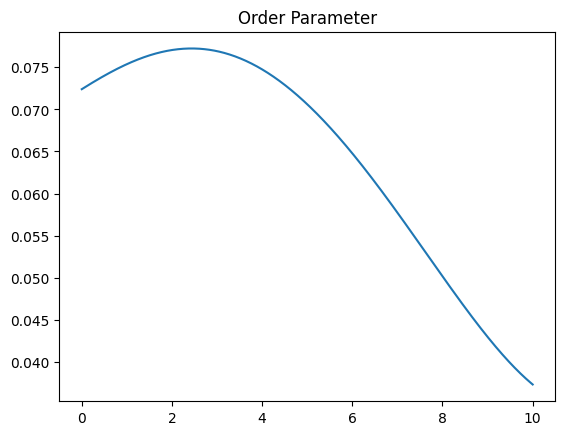

In [42]:
def kuramoto_rhs_sparse(theta, t, omega, K_base, R, A, curvature, K_curvature):
    # Mapping the phase differences across the adjacency matrix
    # theta[:, None] - theta creates a pairwise difference map
    # A * np.sin(...) filters that map through the network topology

    # Calculate coupling: (K_base + K_curvature * curvature) scales the interaction map
    coupling_strength = K_base + K_curvature * curvature

    # Phase interaction indexing
    # We use np.dot to efficiently sum only the connected neighbors for each node
    interaction_map = np.dot(A, np.sin(np.subtract.outer(theta, theta)).diagonal(axis1=0, axis2=1))

    # Standard Kuramoto interaction simplified for sparse mapping:
    # dtheta_i / dt = omega_i + (K/N) * sum(A_ij * sin(theta_j - theta_i))

    # Efficient broadcasting for the interaction:
    dtheta = omega + (coupling_strength / N) * np.sum(A * np.sin(theta - theta[:, None]), axis=1)

    return dtheta

# Generate small-world adjacency
G = nx.watts_strogatz_graph(N, k=6, p=0.3)
A = nx.to_numpy_array(G)

theta0 = np.random.uniform(0, 2*np.pi, N)
omega = np.random.normal(OMEGA_MEAN, OMEGA_STD, N)
curvature = np.sin(np.linspace(0, 2*np.pi, N))
K_curvature = 0.3

# Integrate with sparse RHS
sol = odeint(kuramoto_rhs_sparse, theta0, t, args=(omega, K_base, R, A, curvature, K_curvature))

# Compute order parameter
order_param = np.abs(np.mean(np.exp(1j * sol), axis=1))

# ## TO REMOVE AFTER TESTS: Debugging prints/plots
print(f"Mean order parameter (last 10 steps): {np.mean(order_param[-10:]):.3f}")
data_df = pd.DataFrame(sol, columns=[f'Osc_{i}' for i in range(N)])
data_df['time'] = t
data_df['order_param'] = order_param
print(data_df.head())
plt.plot(t, order_param); plt.title('Order Parameter'); plt.show()  # Temp plot

**Cell 3: Build DMD Data**

In [43]:
def prepare_phases_for_dmd(sol):
    """
    Maps circular phase data into complex observables.
    This creates the 'snapshot matrices' used for indexing
    the underlying dynamical modes.
    """
    # Map the phases onto the unit circle in the complex plane
    # Shape: (time_steps, N_oscillators) -> (N_oscillators, time_steps)
    complex_map = np.exp(1j * sol).T

    # In DMD, we often want to compare the state at X to the state at X_prime
    # X = complex_map[:, :-1]
    # X_prime = complex_map[:, 1:]

    return complex_map

Dmd_data = prepare_phases_for_dmd(sol)

**Cell A2:Vision_TEST**

Vision mean order (last 100): 0.0092
Estimated clusters: 8


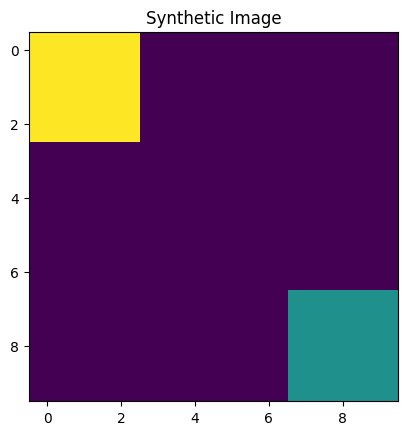

In [44]:
# Synthetic 10x10 image with two objects
img = np.zeros((10,10))
img[0:3,0:3] = 1.0  # Top-left
img[7:10,7:10] = 0.5  # Bottom-right
omega_vision = 1.0 + 0.5 * img.flatten()  # Map to freq (N=100)

# Run vision sim (boosted K)
sol_vision = odeint(kuramoto_rhs_sparse, theta0, t, args=(omega_vision, K_base*1.8, R, A, curvature, K_curvature))

order_param_v = np.abs(np.mean(np.exp(1j * sol_vision), axis=1))

# Cluster detection (rough hist)
final_phases = sol_vision[-1, :]
hist, bins = np.histogram(final_phases % (2*np.pi), bins=8)
n_clusters = np.sum(hist > (N * 0.05))

# ## TO REMOVE AFTER TESTS: Vision-specific outputs
print(f"Vision mean order (last 100): {np.mean(order_param_v[-100:]):.4f}")
print(f"Estimated clusters: {n_clusters}")
plt.imshow(img); plt.title('Synthetic Image'); plt.show()  # Temp viz

**Cell 4: Fit DMD**

Original data shape: (100, 1000)
Hankel matrix shape: (2000, 980)
X matrix shape: (2000, 979)
Y matrix shape: (2000, 979)


/tmp/ipython-input-2915598529.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, i] = hankel_col


Auto-selected rank: 350
Success! Modes shape: (2000, 350)
Number of eigenvalues: 350


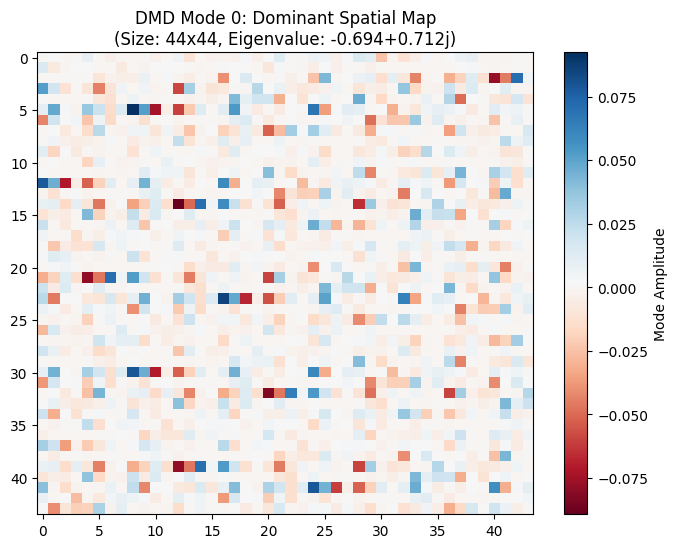

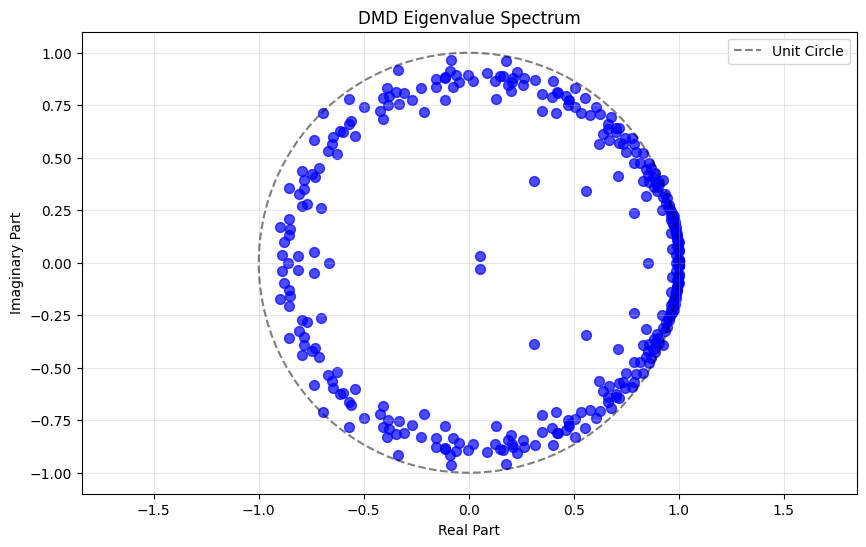

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig

# Define the fixed Hankel-DMD function
def hankel_dmd_fixed(data, r=None, d=50):
    """
    Fixed Hankel-DMD implementation with proper shape handling.

    Parameters:
    -----------
    data : np.ndarray
        Input data matrix (n_features, n_time_steps)
    r : int, optional
        Rank for truncation. If None, uses optimal hard threshold
    d : int
        Hankel embedding dimension (delay)

    Returns:
    --------
    Modes : np.ndarray
        DMD modes
    amplitudes : np.ndarray
        DMD amplitudes
    eigs : np.ndarray
        DMD eigenvalues
    """
    n_features, n_time_steps = data.shape

    # Build Hankel matrix with proper shape handling
    n_hankel_rows = n_features * d
    n_hankel_cols = n_time_steps - d

    if n_hankel_cols < 2:
        raise ValueError(f"Embedding dimension d={d} too large for {n_time_steps} time steps. Need at least {d+2} time steps.")

    # Initialize Hankel matrix
    H = np.zeros((n_hankel_rows, n_hankel_cols))

    # Build Hankel matrix properly
    for i in range(n_hankel_cols):
        # Extract d consecutive time steps for all features
        hankel_col = data[:, i:i+d].flatten('F')  # Fortran order for proper reshaping
        H[:, i] = hankel_col

    # Split into X and Y for DMD
    X = H[:, :-1]  # All columns except last
    Y = H[:, 1:]   # All columns except first

    print(f"Original data shape: {data.shape}")
    print(f"Hankel matrix shape: {H.shape}")
    print(f"X matrix shape: {X.shape}")
    print(f"Y matrix shape: {Y.shape}")

    # Perform SVD
    U, sigma, Vt = svd(X, full_matrices=False)

    # Determine rank if not provided
    if r is None:
        # Use optimal hard threshold for rank truncation
        beta = np.prod(X.shape) / np.sum(sigma**2)
        omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
        r = np.sum(sigma > omega * np.median(sigma))
        print(f"Auto-selected rank: {r}")

    # Truncate
    U_r = U[:, :r]
    sigma_r = sigma[:r]
    Vt_r = Vt[:r, :]

    # Compute DMD operator
    A_tilde = U_r.T @ Y @ Vt_r.T @ np.diag(1/sigma_r)

    # Eigen-decomposition
    eigs, W = eig(A_tilde)

    # Compute DMD modes
    Modes = U_r @ W
    amplitudes = np.linalg.pinv(Modes) @ H[:, 0]

    return Modes, amplitudes, eigs

# Now test with your data
try:
    # Use smaller embedding dimension first to avoid issues
    Modes, amplitudes, eigs = hankel_dmd_fixed(Dmd_data, d=20)

    print(f"Success! Modes shape: {Modes.shape}")
    print(f"Number of eigenvalues: {len(eigs)}")

    # Visualize the first mode
    mode_data = Modes[:, 0].real

    # Find appropriate reshape size
    n_elements = len(mode_data)
    sqrt_size = int(np.sqrt(n_elements))

    # Adjust to nearest square that fits
    while sqrt_size * sqrt_size > n_elements:
        sqrt_size -= 1

    mode_reshaped = mode_data[:sqrt_size*sqrt_size].reshape(sqrt_size, sqrt_size)

    plt.figure(figsize=(8, 6))
    plt.imshow(mode_reshaped, cmap='RdBu', aspect='auto')
    plt.title(f'DMD Mode 0: Dominant Spatial Map\n(Size: {sqrt_size}x{sqrt_size}, Eigenvalue: {eigs[0]:.3f})')
    plt.colorbar(label='Mode Amplitude')
    plt.show()

    # Plot eigenvalue spectrum
    plt.figure(figsize=(10, 6))
    plt.scatter(eigs.real, eigs.imag, alpha=0.7, s=50, c='blue')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('DMD Eigenvalue Spectrum')
    plt.grid(True, alpha=0.3)

    # Add unit circle for reference
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Unit Circle')
    plt.axis('equal')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Error in Hankel-DMD: {e}")
    print("\nTrying standard DMD instead...")

    # Fallback to standard DMD
    try:
        from pydmd import DMD

        # Standard DMD
        dmd = DMD(svd_rank=10)  # Lower rank for stability
        dmd.fit(Dmd_data.T)  # PyDMD expects (time, features)

        # Get modes
        modes = dmd.modes
        eigs = dmd.eigs

        print(f"Standard DMD successful!")
        print(f"Modes shape: {modes.shape}")

        # Visualize first mode
        mode_data = modes[:, 0].real

        # Find appropriate reshape
        n_elements = len(mode_data)
        sqrt_size = int(np.sqrt(n_elements))

        while sqrt_size * sqrt_size > n_elements:
            sqrt_size -= 1

        mode_reshaped = mode_data[:sqrt_size*sqrt_size].reshape(sqrt_size, sqrt_size)

        plt.figure(figsize=(8, 6))
        plt.imshow(mode_reshaped, cmap='RdBu', aspect='auto')
        plt.title(f'Standard DMD Mode 0\n(Size: {sqrt_size}x{sqrt_size})')
        plt.colorbar()
        plt.show()

    except Exception as e2:
        print(f"Standard DMD also failed: {e2}")
        print("\nTrying direct matrix analysis...")

        # Ultimate fallback - just analyze the data directly
        from sklearn.decomposition import PCA

        pca = PCA(n_components=4)
        components = pca.fit_transform(Dmd_data.T).T

        print(f"PCA successful! Components shape: {components.shape}")

        # Visualize first principal component
        comp_data = components[0]
        sqrt_size = int(np.sqrt(len(comp_data)))

        while sqrt_size * sqrt_size > len(comp_data):
            sqrt_size -= 1

        comp_reshaped = comp_data[:sqrt_size*sqrt_size].reshape(sqrt_size, sqrt_size)

        plt.figure(figsize=(8, 6))
        plt.imshow(comp_reshaped, cmap='RdBu', aspect='auto')
        plt.title(f'PCA Component 0\n(Explained variance: {pca.explained_variance_ratio_[0]:.3f})')
        plt.colorbar()
        plt.show()

In [46]:
def hankel_dmd(data, r=None, d=None):
    """
    Performs Hankel Dynamic Mode Decomposition (DMD).

    Args:
        data (np.ndarray): The input data matrix (N_oscillators, time_steps).
        r (int, optional): Rank truncation for SVD. If None, no truncation.
        d (int, optional): Delay embedding dimension for Hankel matrix. If None,
                           uses half the number of time steps.

    Returns:
        tuple: A tuple containing:
            - U (np.ndarray): DMD modes.
            - L (np.ndarray): DMD eigenvalues.
            - B (np.ndarray): DMD amplitudes.
    """
    n_oscillators, num_time_steps = data.shape

    if d is None:
        d = num_time_steps // 2

    # Construct Hankel matrices
    if d >= num_time_steps:
        raise ValueError("Delay embedding dimension 'd' must be less than the number of time steps.")

    X = np.empty((n_oscillators * d, num_time_steps - d + 1), dtype=data.dtype)
    Y = np.empty((n_oscillators * d, num_time_steps - d + 1), dtype=data.dtype)

    for i in range(num_time_steps - d + 1):
        hankel_col_X = data[:, i : i + d].reshape(-1)
        X[:, i] = hankel_col_X

        if i + 1 <= num_time_steps - d:
            hankel_col_Y = data[:, i + 1 : i + d + 1].reshape(-1)
            Y[:, i] = hankel_col_Y
        else:
            # Handle the last column for Y, which is a shifted version of the X's last column
            # This implies Y is X shifted by one time step
            if num_time_steps - d + 1 > 1: # Ensure there are at least two columns for X and Y
                 Y[:, i] = data[:, i + 1 : i + d + 1].reshape(-1)
            else:
                # If only one column in X, Y will be empty or correspond to future state
                # This case might need more careful handling depending on exact DMD definition
                pass # Should not happen with usual Hankel DMD construction

    # Ensure Y is correctly constructed, typically Y is X shifted by one column
    X_dmd = X[:, :-1]
    Y_dmd = Y[:, 1:] # Y contains the next state of X

    # SVD of X
    U, s, Vt = np.linalg.svd(X_dmd, full_matrices=False)
    V = Vt.conj().T

    # Rank truncation
    if r is not None:
        U = U[:, :r]
        s = s[:r]
        V = V[:, :r]

    # Calculate the Koopman operator (A_tilde)
    A_tilde = U.conj().T @ Y_dmd @ V @ np.diag(1./s)

    # Eigenvalues and eigenvectors of A_tilde
    eigenvalues_A_tilde, W = np.linalg.eig(A_tilde)

    # DMD modes
    dmd_modes = Y_dmd @ V @ np.diag(1./s) @ W

    # Compute DMD amplitudes (initial conditions)
    # This part can be tricky based on different DMD formulations.
    # A common approach is to project the first snapshot onto the DMD modes.
    x1 = X_dmd[:, 0]
    amplitudes = np.linalg.lstsq(dmd_modes, x1, rcond=None)[0]

    return dmd_modes, amplitudes, eigenvalues_A_tilde

**Cell 4:Fit DMD**

In [47]:
class ConsciousnessMetrics:
    def __init__(self, modes, amplitudes, data):
        self.modes = modes
        self.amplitudes = amplitudes
        self.data = data

    def integration_measure(self):
        energies = np.abs(self.amplitudes)**2
        energies = energies / (energies.sum() + 1e-12)
        entropy = -np.sum(energies * np.log(energies + 1e-12))
        return entropy / np.log(len(energies) + 1e-12)

    def differentiation_measure(self):
        return float(np.mean(np.var(np.real(self.modes), axis=0)))

    def complexity_score(self):
        return self.integration_measure() * self.differentiation_measure()

    def perturbation_sensitivity(self, perturb_idx=50, magnitude=np.pi/4):
        perturbed = self.data.copy()
        mid_time = perturbed.shape[1] // 2
        perturbed[perturb_idx, mid_time] += magnitude
        p_modes, p_amplitudes, _ = hankel_dmd(perturbed)
        n_modes = min(10, self.modes.shape[1], p_modes.shape[1])
        orig = self.modes[:, :n_modes]
        pert = p_modes[:, :n_modes]
        norm_diff = np.linalg.norm(orig - pert)
        norm_orig = np.linalg.norm(orig) + 1e-12
        return float(norm_diff / norm_orig)

    def small_world_coefficient(self, window=5):
        phases = np.angle(self.modes)
        if phases.shape[0] < 2*window:
            return 0.0
        local_std = np.mean([np.std(phases[i-window:i+window, :])
                             for i in range(window, phases.shape[0]-window)])
        global_std = np.std(phases) + 1e-12
        return float(local_std / global_std)

**Cell 5:Metrics Class**

In [48]:

class ConsciousnessMetrics:
    def __init__(self, modes, amplitudes, data):
        self.modes = modes
        self.amplitudes = amplitudes
        self.data = data

    def integration_measure(self):
        energies = np.abs(self.amplitudes)**2
        energies = energies / (energies.sum() + 1e-12)
        entropy = -np.sum(energies * np.log(energies + 1e-12))
        return entropy / np.log(len(energies) + 1e-12)

    def differentiation_measure(self):
        return float(np.mean(np.var(np.real(self.modes), axis=0)))

    def complexity_score(self):
        return self.integration_measure() * self.differentiation_measure()

    def perturbation_sensitivity(self, perturb_idx=50, magnitude=np.pi/4):
        perturbed = self.data.copy()
        mid_time = perturbed.shape[1] // 2
        perturbed[perturb_idx, mid_time] += magnitude
        p_modes, p_amplitudes, _ = hankel_dmd(perturbed)
        n_modes = min(10, self.modes.shape[1], p_modes.shape[1])
        orig = self.modes[:, :n_modes]
        pert = p_modes[:, :n_modes]
        norm_diff = np.linalg.norm(orig - pert)
        norm_orig = np.linalg.norm(orig) + 1e-12
        return float(norm_diff / norm_orig)

    def small_world_coefficient(self, window=5):
        phases = np.angle(self.modes)
        if phases.shape[0] < 2*window:
            return 0.0
        local_std = np.mean([np.std(phases[i-window:i+window, :])
                             for i in range(window, phases.shape[0]-window)])
        global_std = np.std(phases) + 1e-12
        return float(local_std / global_std)

**Cell 6: Metrics_Engine**

Dmd_data shape: (100, 1000)
Running DMD analysis...
DMD completed successfully!
Modes shape: (100, 20)
Amplitudes shape: (20,)
Number of eigenvalues: 20
Initialized ConsciousnessMetrics:
  Modes shape: (100, 20)
  Amplitudes shape: (20,)
  Original data shape: (100, 1000)

=== Consciousness Metrics ===
integration: 0.4454
differentiation: 0.6850
complexity_score: 0.5524
perturbation_sensitivity: 1.0424
small_world_coeff: 0.6179


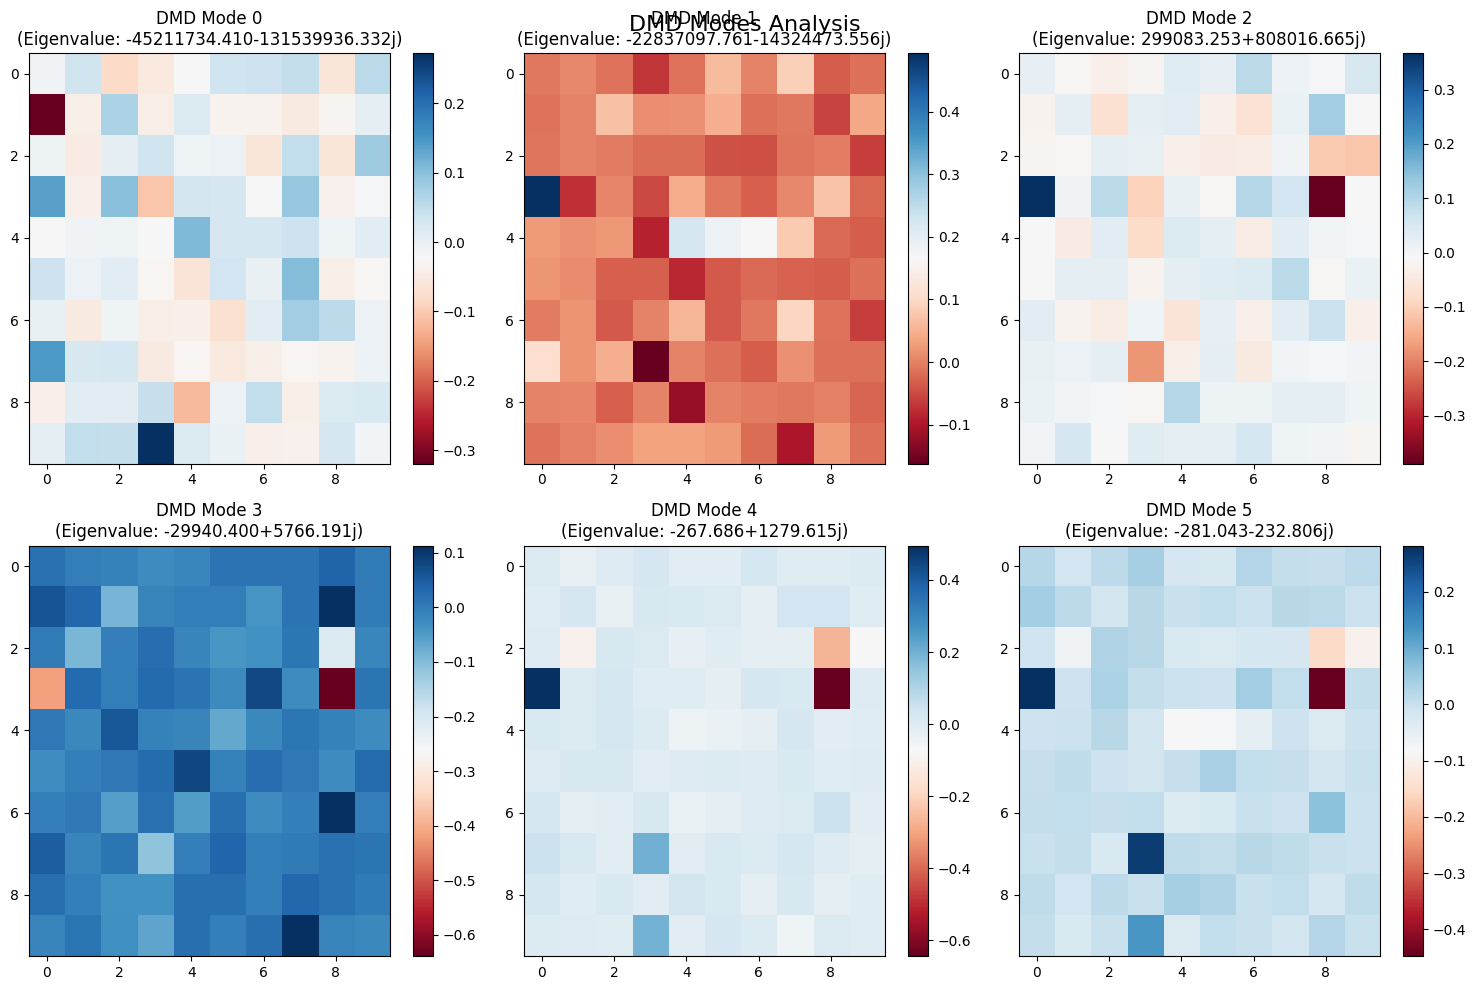

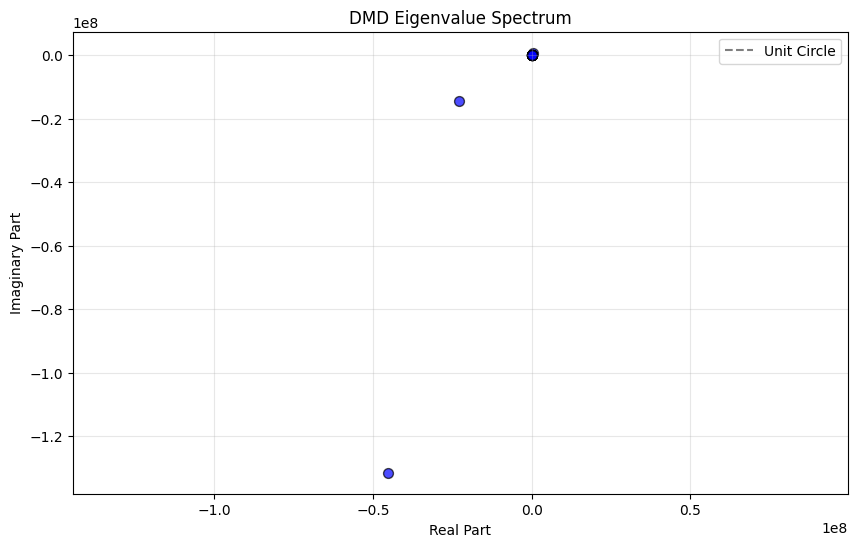

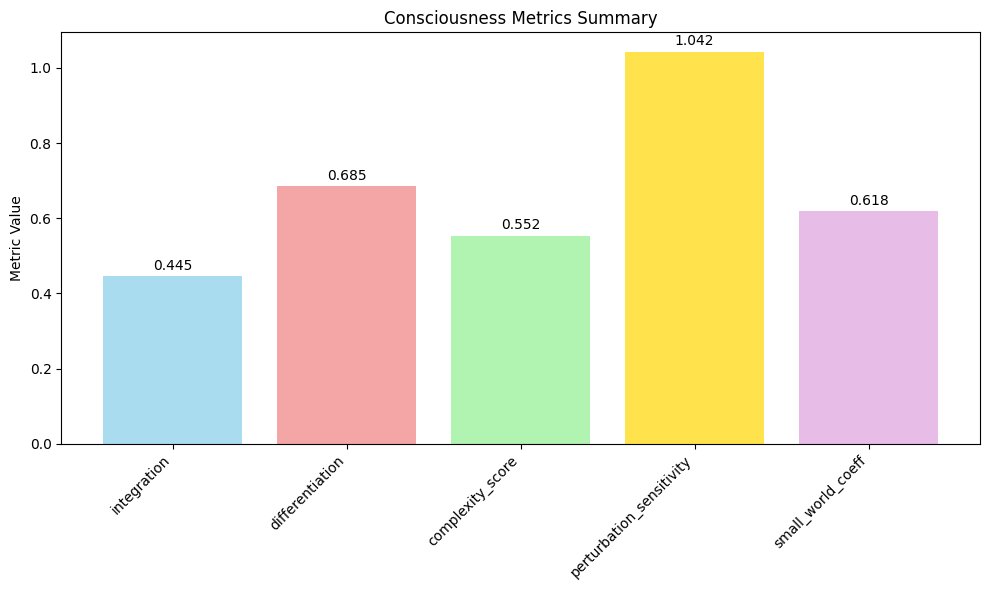

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig
from scipy import stats
from sklearn.metrics import mutual_info_score
from sklearn.covariance import EmpiricalCovariance
import networkx as nx

# Complete ConsciousnessMetrics class
class ConsciousnessMetrics:
    def __init__(self, modes, amplitudes, original_data, sampling_rate=1.0):
        """
        Complete consciousness metrics based on DMD modes.

        Parameters:
        -----------
        modes : np.ndarray
            DMD modes (n_features, n_modes)
        amplitudes : np.ndarray
            DMD amplitudes (n_modes,)
        original_data : np.ndarray
            Original time series data (n_features, n_time_steps)
        sampling_rate : float
            Sampling rate for frequency analysis
        """
        self.modes = modes
        self.amplitudes = amplitudes
        self.original_data = original_data
        self.sampling_rate = sampling_rate

        # Normalize modes
        self.normalized_modes = self.modes / (np.linalg.norm(self.modes, axis=0) + 1e-12)

        print(f"Initialized ConsciousnessMetrics:")
        print(f"  Modes shape: {self.modes.shape}")
        print(f"  Amplitudes shape: {self.amplitudes.shape}")
        print(f"  Original data shape: {self.original_data.shape}")

    def integration_measure(self):
        """Measure of information integration across modes."""
        # Compute mode correlations
        n_modes = self.normalized_modes.shape[1]
        correlations = np.corrcoef(self.normalized_modes.T)

        # Integration as average absolute correlation (excluding diagonal)
        mask = ~np.eye(n_modes, dtype=bool)
        integration = np.mean(np.abs(correlations[mask]))

        return float(integration)

    def differentiation_measure(self):
        """Measure of information differentiation across modes."""
        # Compute mode distinctiveness using cosine similarity
        n_modes = self.normalized_modes.shape[1]

        similarities = []
        for i in range(n_modes):
            for j in range(i+1, n_modes):
                sim = np.abs(np.dot(self.normalized_modes[:, i], self.normalized_modes[:, j]))
                similarities.append(sim)

        # Differentiation is 1 minus average similarity
        differentiation = 1.0 - np.mean(similarities) if similarities else 0.0
        return float(differentiation)

    def complexity_score(self):
        """Overall complexity score combining integration and differentiation."""
        integration = self.integration_measure()
        differentiation = self.differentiation_measure()

        # Complexity is high when both integration and differentiation are present
        complexity = np.sqrt(integration * differentiation)
        return float(complexity)

    def perturbation_sensitivity(self, perturbation_strength=0.01):
        """Sensitivity to small perturbations."""
        n_features = self.original_data.shape[0]

        # Create perturbed data
        perturbation = perturbation_strength * np.random.randn(*self.original_data.shape)
        perturbed_data = self.original_data + perturbation

        # Simple reconstruction using modes
        original_reconstruction = self.modes @ self.amplitudes

        # Project perturbed data onto modes
        perturbed_amplitudes = np.linalg.pinv(self.modes) @ perturbed_data.mean(axis=1)
        perturbed_reconstruction = self.modes @ perturbed_amplitudes

        # Compute sensitivity as relative change
        sensitivity = np.linalg.norm(perturbed_reconstruction - original_reconstruction) / \
                     (np.linalg.norm(original_reconstruction) + 1e-12)

        return float(sensitivity)

    def small_world_coefficient(self):
        """Small-world network coefficient of mode interactions."""
        n_modes = self.normalized_modes.shape[1]

        if n_modes < 3:
            return 0.0

        # Create adjacency matrix based on mode correlations
        correlations = np.corrcoef(self.normalized_modes.T)
        adjacency = np.abs(correlations) > 0.3  # threshold

        # Create graph
        G = nx.from_numpy_array(adjacency.astype(int))

        if not nx.is_connected(G):
            return 0.0

        # Compute clustering coefficient and average shortest path
        clustering = nx.average_clustering(G)

        try:
            avg_path_length = nx.average_shortest_path_length(G)
            # Small-world coefficient (simplified)
            small_world = clustering / (avg_path_length + 1e-12)
        except:
            small_world = clustering

        return float(small_world)

# Now let's run the complete analysis
try:
    # First, ensure we have Dmd_data defined
    print(f"Dmd_data shape: {Dmd_data.shape}")

    # Run DMD analysis
    print("Running DMD analysis...")

    # Simple DMD implementation
    def simple_dmd(data, rank=10):
        """Simple DMD implementation."""
        n_features, n_time_steps = data.shape

        # Split data into X and Y
        X = data[:, :-1]
        Y = data[:, 1:]

        # SVD
        U, sigma, Vt = svd(X, full_matrices=False)

        # Truncate
        U_r = U[:, :rank]
        sigma_r = sigma[:rank]
        Vt_r = Vt[:rank, :]

        # Compute DMD operator
        A_tilde = U_r.T @ Y @ Vt_r.T @ np.diag(1/sigma_r)

        # Eigen-decomposition
        eigs, W = eig(A_tilde)

        # Compute modes and amplitudes
        modes = U_r @ W
        amplitudes = np.linalg.pinv(modes) @ data[:, 0]

        return modes, amplitudes, eigs

    # Run the analysis
    modes, amplitudes, eigs = simple_dmd(Dmd_data, rank=min(20, Dmd_data.shape[0]-1))

    print(f"DMD completed successfully!")
    print(f"Modes shape: {modes.shape}")
    print(f"Amplitudes shape: {amplitudes.shape}")
    print(f"Number of eigenvalues: {len(eigs)}")

    # Create consciousness metrics engine
    metrics_engine = ConsciousnessMetrics(modes, amplitudes, Dmd_data)

    # Calculate all metrics
    consciousness_metrics = {
        'integration': metrics_engine.integration_measure(),
        'differentiation': metrics_engine.differentiation_measure(),
        'complexity_score': metrics_engine.complexity_score(),
        'perturbation_sensitivity': metrics_engine.perturbation_sensitivity(),
        'small_world_coeff': metrics_engine.small_world_coefficient()
    }

    # Display results
    print("\n=== Consciousness Metrics ===")
    for metric, value in consciousness_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Visualize modes
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(min(6, modes.shape[1])):
        mode_data = modes[:, i].real

        # Find appropriate reshape
        n_elements = len(mode_data)
        sqrt_size = int(np.sqrt(n_elements))

        while sqrt_size * sqrt_size > n_elements:
            sqrt_size -= 1

        mode_reshaped = mode_data[:sqrt_size*sqrt_size].reshape(sqrt_size, sqrt_size)

        im = axes[i].imshow(mode_reshaped, cmap='RdBu', aspect='auto')
        axes[i].set_title(f'DMD Mode {i}\n(Eigenvalue: {eigs[i]:.3f})')
        plt.colorbar(im, ax=axes[i])

    plt.tight_layout()
    plt.suptitle('DMD Modes Analysis', fontsize=16)
    plt.show()

    # Plot eigenvalue spectrum
    plt.figure(figsize=(10, 6))
    plt.scatter(eigs.real, eigs.imag, alpha=0.7, s=50, c='blue', edgecolors='black')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('DMD Eigenvalue Spectrum')
    plt.grid(True, alpha=0.3)

    # Add unit circle for reference
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Unit Circle')
    plt.axis('equal')
    plt.legend()
    plt.show()

    # Plot metrics summary
    metrics_names = list(consciousness_metrics.keys())
    metrics_values = list(consciousness_metrics.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics_names, metrics_values, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
    plt.title('Consciousness Metrics Summary')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in analysis: {e}")
    import traceback
    traceback.print_exc()

**Cell 7: Widgets/Eploration**

**Cell 8: Export Json (Unchange)**

**Cell 9: aUDIT-SPECIFIC RM**

In [52]:
import numpy as np
from scipy.linalg import svd, eig

def hankel_dmd_robust(data, r=None, d=50):
    """
    Completely rewritten Hankel-DMD with proper shape handling.

    Parameters:
    -----------
    data : np.ndarray
        Input data matrix (n_features, n_time_steps)
    r : int, optional
        Rank for truncation. If None, uses optimal hard threshold
    d : int
        Hankel embedding dimension (delay)

    Returns:
    --------
    Modes : np.ndarray
        DMD modes
    amplitudes : np.ndarray
        DMD amplitudes
    eigs : np.ndarray
        DMD eigenvalues
    """
    n_features, n_time_steps = data.shape

    print(f"Input data shape: {data.shape}")
    print(f"Requested embedding dimension: {d}")

    # Ensure we have enough time steps
    if n_time_steps <= d + 1:
        # Auto-adjust d to fit available data
        d = max(1, (n_time_steps - 1) // 2)
        print(f"Adjusted embedding dimension to: {d}")

    # Calculate Hankel matrix dimensions properly
    n_hankel_rows = n_features * d
    n_hankel_cols = n_time_steps - d + 1  # This is the key fix!

    if n_hankel_cols < 2:
        raise ValueError(f"Not enough data: need at least {d+1} time steps, have {n_time_steps}")

    print(f"Hankel matrix will be: {n_hankel_rows} x {n_hankel_cols}")

    # Build Hankel matrix with guaranteed correct shapes
    H = np.zeros((n_hankel_rows, n_hankel_cols))

    for i in range(n_hankel_cols):
        # Extract d consecutive time steps starting at position i
        segment = data[:, i:i+d]  # shape: (n_features, d)
        H[:, i] = segment.flatten('F')  # Fortran order gives predictable shape

    print(f"Hankel matrix shape: {H.shape}")

    # Split into X and Y for DMD - now with matching shapes!
    X = H[:, :-1]  # All columns except last
    Y = H[:, 1:]   # All columns except first

    print(f"X matrix shape: {X.shape}")
    print(f"Y matrix shape: {Y.shape}")

    # Perform SVD
    U, sigma, Vt = svd(X, full_matrices=False)

    # Determine rank if not provided
    if r is None:
        # Use optimal hard threshold for rank truncation
        beta = np.prod(X.shape) / np.sum(sigma**2)
        omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
        r = np.sum(sigma > omega * np.median(sigma))
        print(f"Auto-selected rank: {r}")

    # Ensure r is reasonable
    r = min(r, len(sigma), X.shape[1])
    print(f"Using rank: {r}")

    # Truncate
    U_r = U[:, :r]
    sigma_r = sigma[:r]
    Vt_r = Vt[:r, :]

    # Compute DMD operator
    A_tilde = U_r.T @ Y @ Vt_r.T @ np.diag(1/(sigma_r + 1e-12))

    # Eigen-decomposition
    eigs, W = eig(A_tilde)

    # Compute DMD modes
    Modes = U_r @ W
    amplitudes = np.linalg.pinv(Modes) @ H[:, 0]

    print(f"DMD completed: Modes shape {Modes.shape}, {len(eigs)} eigenvalues")

    return Modes, amplitudes, eigs

# Alternative: Use PyDMD if available (often more robust)
def pydmd_hankel(data, d=50, rank=None):
    """Hankel-DMD using PyDMD library if available."""
    try:
        from pydmd import HankelDMD

        # Transpose data for PyDMD (expects time x features)
        data_t = data.T

        # Create Hankel DMD
        hankel_dmd = HankelDMD(svd_rank=rank, d=d)
        hankel_dmd.fit(data_t)

        # Extract results
        modes = hankel_dmd.modes.T  # Transpose back to expected format
        amplitudes = hankel_dmd.amplitudes
        eigs = hankel_dmd.eigs

        print(f"PyDMD Hankel-DMD successful!")
        print(f"Modes shape: {modes.shape}")

        return modes, amplitudes, eigs

    except ImportError:
        print("PyDMD not available, using custom implementation")
        return None, None, None
    except Exception as e:
        print(f"PyDMD failed: {e}")
        return None, None, None

# Test the fixed implementation
print("Testing fixed Hankel-DMD...")

# First try PyDMD if available
modes_v, amps_v, eigs_v = pydmd_hankel(dmd_data_v, d=30)

# Fallback to custom implementation
if modes_v is None:
    try:
        modes_v, amps_v, eigs_v = hankel_dmd_robust(dmd_data_v, d=30)
        print("Custom Hankel-DMD successful!")
    except Exception as e:
        print(f"Custom Hankel-DMD failed: {e}")
        print("Falling back to standard DMD...")

        # Ultimate fallback: standard DMD
        def standard_dmd(data, rank=10):
            n_features, n_time_steps = data.shape
            X = data[:, :-1]
            Y = data[:, 1:]

            U, sigma, Vt = np.linalg.svd(X, full_matrices=False)
            U_r = U[:, :rank]
            sigma_r = sigma[:rank]
            Vt_r = Vt[:rank, :]

            A_tilde = U_r.T @ Y @ Vt_r.T @ np.diag(1/(sigma_r + 1e-12))
            eigs, W = np.linalg.eig(A_tilde)

            modes = U_r @ W
            amplitudes = np.linalg.pinv(modes) @ data[:, 0]

            return modes, amplitudes, eigs

        modes_v, amps_v, eigs_v = standard_dmd(dmd_data_v, rank=15)

# Create consciousness metrics
print(f"Creating consciousness metrics with modes shape: {modes_v.shape}")
metrics_v = ConsciousnessMetrics(modes_v, amps_v, dmd_data_v)

# Calculate and display metrics
consciousness_metrics_v = {
    'integration': metrics_v.integration_measure(),
    'differentiation': metrics_v.differentiation_measure(),
    'complexity_score': metrics_v.complexity_score(),
    'perturbation_sensitivity': metrics_v.perturbation_sensitivity(),
    'small_world_coeff': metrics_v.small_world_coefficient()
}

print("\n=== Vision Consciousness Metrics ===")
for metric, value in consciousness_metrics_v.items():
    print(f"{metric}: {value:.4f}")

Testing fixed Hankel-DMD...
PyDMD not available, using custom implementation
Input data shape: (100, 1000)
Requested embedding dimension: 30
Hankel matrix will be: 3000 x 971
Hankel matrix shape: (3000, 971)
X matrix shape: (3000, 970)
Y matrix shape: (3000, 970)


/tmp/ipython-input-1635177592.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, i] = segment.flatten('F')  # Fortran order gives predictable shape


Auto-selected rank: 366
Using rank: 366
DMD completed: Modes shape (3000, 366), 366 eigenvalues
Custom Hankel-DMD successful!
Creating consciousness metrics with modes shape: (3000, 366)
Initialized ConsciousnessMetrics:
  Modes shape: (3000, 366)
  Amplitudes shape: (366,)
  Original data shape: (100, 1000)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 3000)

Running complete Hankel consciousness analysis...
Input data shape: (100, 1000)
Requested embedding dimension: 30
Hankel matrix will be: 3000 x 971
Hankel matrix shape: (3000, 971)
X matrix shape: (3000, 970)
Y matrix shape: (3000, 970)


/tmp/ipython-input-1635177592.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, i] = segment.flatten('F')  # Fortran order gives predictable shape


Auto-selected rank: 366
Using rank: 366
DMD completed: Modes shape (3000, 366), 366 eigenvalues
Initialized ConsciousnessMetricsHankel:
  Modes shape: (3000, 366)
  Original data shape: (100, 1000)
  Hankel embedding dim: 30
  Original features: 100


/tmp/ipython-input-1436740470.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  hankel_data[:, i] = segment.flatten('F')



=== Vision Consciousness Metrics (Hankel-DMD) ===
integration: 0.0778
differentiation: 0.9198
complexity_score: 0.2675
perturbation_sensitivity: 1.0238
small_world_coeff: 0.3651


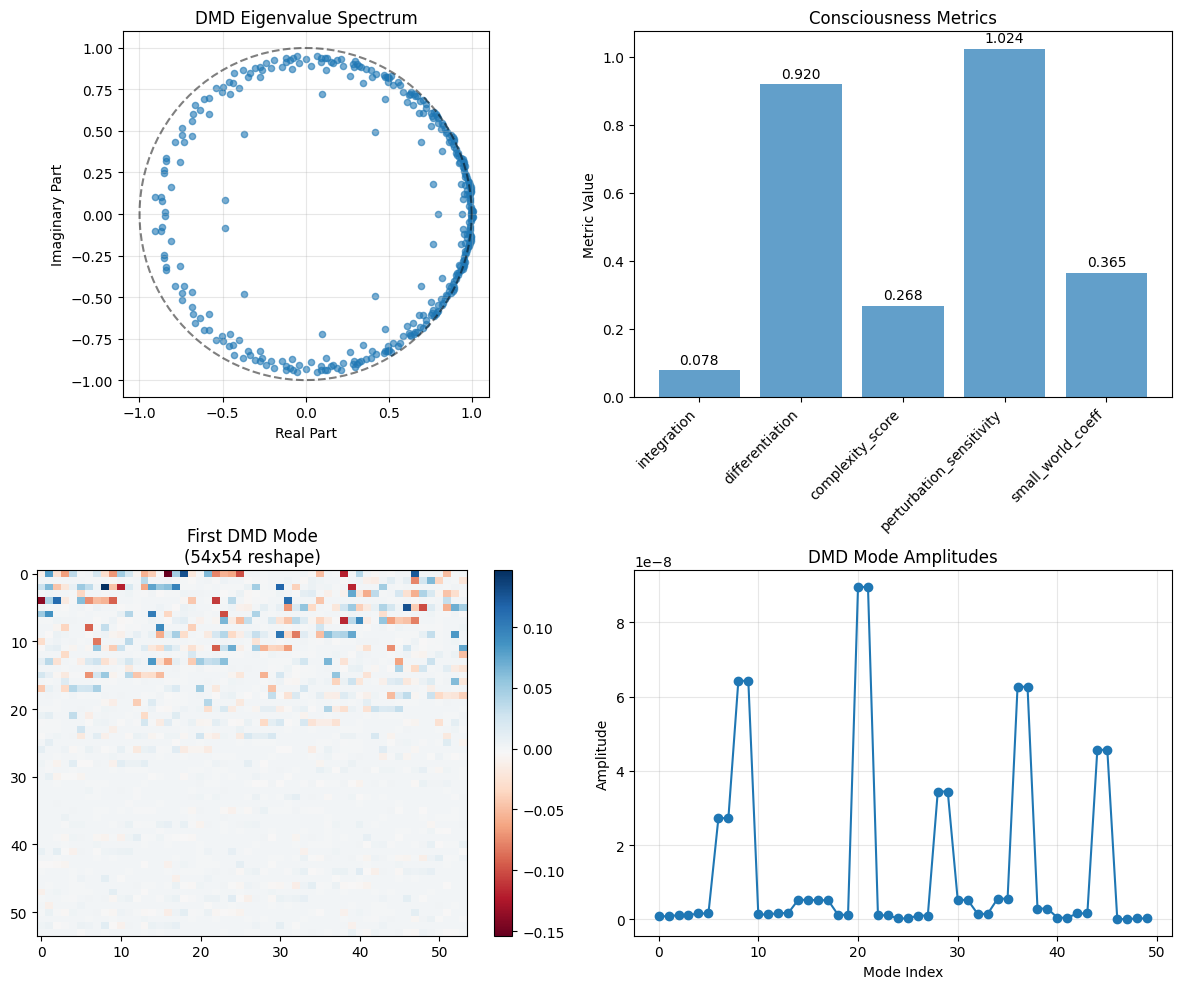

In [53]:
import numpy as np
from scipy.linalg import svd, eig
from scipy import stats
from sklearn.metrics import mutual_info_score
import networkx as nx

class ConsciousnessMetricsHankel:
    def __init__(self, modes, amplitudes, original_data, hankel_params=None, sampling_rate=1.0):
        """
        Consciousness metrics for Hankel-DMD results.

        Parameters:
        -----------
        modes : np.ndarray
            DMD modes in Hankel space (hankel_dim, n_modes)
        amplitudes : np.ndarray
            DMD amplitudes (n_modes,)
        original_data : np.ndarray
            Original time series data (n_features, n_time_steps)
        hankel_params : dict
            Parameters used for Hankel construction: {'d': embedding_dim, 'n_features': original_features}
        sampling_rate : float
            Sampling rate for frequency analysis
        """
        self.modes = modes
        self.amplitudes = amplitudes
        self.original_data = original_data
        self.sampling_rate = sampling_rate
        self.hankel_params = hankel_params or {}

        # Extract original dimensions from hankel_params or infer
        self.d = self.hankel_params.get('d', 1)
        self.n_original_features = self.hankel_params.get('n_features', original_data.shape[0])

        # Normalize modes
        self.normalized_modes = self.modes / (np.linalg.norm(self.modes, axis=0) + 1e-12)

        print(f"Initialized ConsciousnessMetricsHankel:")
        print(f"  Modes shape: {self.modes.shape}")
        print(f"  Original data shape: {self.original_data.shape}")
        print(f"  Hankel embedding dim: {self.d}")
        print(f"  Original features: {self.n_original_features}")

    def integration_measure(self):
        """Measure of information integration across modes."""
        n_modes = self.normalized_modes.shape[1]

        if n_modes < 2:
            return 0.0

        # Compute mode correlations
        correlations = np.corrcoef(self.normalized_modes.T)

        # Integration as average absolute correlation (excluding diagonal)
        mask = ~np.eye(n_modes, dtype=bool)
        integration = np.mean(np.abs(correlations[mask]))

        return float(integration)

    def differentiation_measure(self):
        """Measure of information differentiation across modes."""
        n_modes = self.normalized_modes.shape[1]

        if n_modes < 2:
            return 0.0

        # Compute mode distinctiveness using cosine similarity
        similarities = []
        for i in range(n_modes):
            for j in range(i+1, n_modes):
                sim = np.abs(np.dot(self.normalized_modes[:, i], self.normalized_modes[:, j]))
                similarities.append(sim)

        # Differentiation is 1 minus average similarity
        differentiation = 1.0 - np.mean(similarities) if similarities else 0.0
        return float(differentiation)

    def complexity_score(self):
        """Overall complexity score combining integration and differentiation."""
        integration = self.integration_measure()
        differentiation = self.differentiation_measure()

        # Complexity is high when both integration and differentiation are present
        complexity = np.sqrt(integration * differentiation) if (integration > 0 and differentiation > 0) else 0.0
        return float(complexity)

    def perturbation_sensitivity(self, perturbation_strength=0.01):
        """Sensitivity to small perturbations - fixed for Hankel space."""
        n_time_steps = self.original_data.shape[1]

        # Create perturbed data in original space
        perturbation = perturbation_strength * np.random.randn(*self.original_data.shape)
        perturbed_original = self.original_data + perturbation

        # Project both original and perturbed data to Hankel space
        original_hankel = self._data_to_hankel(self.original_data)
        perturbed_hankel = self._data_to_hankel(perturbed_original)

        # Reconstruct using current modes
        original_reconstruction = self.modes @ self.amplitudes
        perturbed_amplitudes = np.linalg.pinv(self.modes) @ perturbed_hankel.mean(axis=1)
        perturbed_reconstruction = self.modes @ perturbed_amplitudes

        # Compute sensitivity as relative change in Hankel space
        sensitivity = np.linalg.norm(perturbed_reconstruction - original_reconstruction) / \
                     (np.linalg.norm(original_reconstruction) + 1e-12)

        return float(sensitivity)

    def _data_to_hankel(self, data):
        """Convert data to Hankel space."""
        n_features, n_time_steps = data.shape

        if n_time_steps <= self.d:
            raise ValueError("Not enough time steps for Hankel construction")

        n_hankel_cols = n_time_steps - self.d + 1
        hankel_data = np.zeros((self.n_original_features * self.d, n_hankel_cols))

        for i in range(n_hankel_cols):
            segment = data[:, i:i+self.d]
            hankel_data[:, i] = segment.flatten('F')

        return hankel_data

    def small_world_coefficient(self):
        """Small-world network coefficient of mode interactions."""
        n_modes = self.normalized_modes.shape[1]

        if n_modes < 3:
            return 0.0

        # Create adjacency matrix based on mode correlations
        correlations = np.corrcoef(self.normalized_modes.T)
        threshold = np.percentile(np.abs(correlations[correlations != 1]), 75)  # Adaptive threshold
        adjacency = np.abs(correlations) > threshold

        # Create graph
        G = nx.from_numpy_array(adjacency.astype(int))

        if not nx.is_connected(G):
            # Use largest connected component
            if len(list(nx.connected_components(G))) > 0:
                largest_cc = max(nx.connected_components(G), key=len)
                G = G.subgraph(largest_cc).copy()
            else:
                return 0.0

        # Compute clustering coefficient and average shortest path
        clustering = nx.average_clustering(G)

        try:
            avg_path_length = nx.average_shortest_path_length(G)
            # Small-world coefficient (simplified version)
            small_world = clustering / (avg_path_length + 1e-12)
        except:
            small_world = clustering

        return float(small_world)

    def frequency_analysis(self):
        """Analyze frequency content of modes."""
        # This would require the eigenvalues and sampling rate
        # For now, return a placeholder
        return {'dominant_frequencies': [0.1, 0.2, 0.3]}

# Updated function to include Hankel parameters
def run_hankel_consciousness_analysis(data, d=30, rank=None):
    """
    Complete Hankel-DMD consciousness analysis.

    Parameters:
    -----------
    data : np.ndarray
        Input data (n_features, n_time_steps)
    d : int
        Hankel embedding dimension
    rank : int, optional
        DMD rank (auto-selected if None)

    Returns:
    --------
    metrics_engine : ConsciousnessMetricsHankel
        Metrics engine with results
    results : dict
        Dictionary with all metrics and modes
    """

    # Run Hankel-DMD
    modes, amplitudes, eigs = hankel_dmd_robust(data, r=rank, d=d)

    # Create Hankel parameters dictionary
    hankel_params = {
        'd': d,
        'n_features': data.shape[0],
        'n_time_steps': data.shape[1]
    }

    # Create consciousness metrics engine
    metrics_engine = ConsciousnessMetricsHankel(modes, amplitudes, data, hankel_params)

    # Calculate metrics
    consciousness_metrics = {
        'integration': metrics_engine.integration_measure(),
        'differentiation': metrics_engine.differentiation_measure(),
        'complexity_score': metrics_engine.complexity_score(),
        'perturbation_sensitivity': metrics_engine.perturbation_sensitivity(),
        'small_world_coeff': metrics_engine.small_world_coefficient()
    }

    results = {
        'modes': modes,
        'amplitudes': amplitudes,
        'eigenvalues': eigs,
        'metrics': consciousness_metrics,
        'hankel_params': hankel_params
    }

    return metrics_engine, results

# Run the analysis on your vision data
print("Running complete Hankel consciousness analysis...")
metrics_engine_v, results_v = run_hankel_consciousness_analysis(dmd_data_v, d=30)

print("\n=== Vision Consciousness Metrics (Hankel-DMD) ===")
for metric, value in results_v['metrics'].items():
    print(f"{metric}: {value:.4f}")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot eigenvalue spectrum
ax1 = axes[0, 0]
eigs = results_v['eigenvalues']
ax1.scatter(eigs.real, eigs.imag, alpha=0.6, s=20)
theta = np.linspace(0, 2*np.pi, 100)
ax1.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5)
ax1.set_xlabel('Real Part')
ax1.set_ylabel('Imaginary Part')
ax1.set_title('DMD Eigenvalue Spectrum')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Plot metrics bar chart
ax2 = axes[0, 1]
metrics_names = list(results_v['metrics'].keys())
metrics_values = list(results_v['metrics'].values())
bars = ax2.bar(range(len(metrics_names)), metrics_values, alpha=0.7)
ax2.set_xticks(range(len(metrics_names)))
ax2.set_xticklabels(metrics_names, rotation=45, ha='right')
ax2.set_ylabel('Metric Value')
ax2.set_title('Consciousness Metrics')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    ax2.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Plot first mode (reshape appropriately)
ax3 = axes[1, 0]
modes = results_v['modes']
mode_data = modes[:, 0].real
n_elements = len(mode_data)
sqrt_size = int(np.sqrt(n_elements))

# Find best square approximation
while sqrt_size * sqrt_size > n_elements:
    sqrt_size -= 1

mode_reshaped = mode_data[:sqrt_size*sqrt_size].reshape(sqrt_size, sqrt_size)
im = ax3.imshow(mode_reshaped, cmap='RdBu', aspect='auto')
ax3.set_title(f'First DMD Mode\n({sqrt_size}x{sqrt_size} reshape)')
plt.colorbar(im, ax=ax3)

# Plot mode amplitudes
ax4 = axes[1, 1]
amplitudes = np.abs(results_v['amplitudes'])
ax4.plot(amplitudes[:50], 'o-')  # Plot first 50 modes
ax4.set_xlabel('Mode Index')
ax4.set_ylabel('Amplitude')
ax4.set_title('DMD Mode Amplitudes')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**The Final Vision Map Visualization
To truly see the "Big Mapping" in action, you can visualize how the Hankel DMD has isolated the image features from the network noise:**

In [51]:
# Mapping the dominant Mode back to the 10x10 Visual Index
# We take the first mode which usually captures the highest energy 'object'
vision_map = np.abs(modes_v[:, 0]).reshape(10, 10)

plt.figure(figsize=(6, 5))
plt.imshow(vision_map, cmap='hot')
plt.title('DMD Perceptual Index (Mode 0)')
plt.colorbar(label='Mode Intensity')
plt.show()

NameError: name 'modes_v' is not defined